In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def plot(data):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
    data["date"] = pd.to_datetime(data["date"])

    axs[0].plot(data["date"], data["gdp"], label="GDP", color="b")
    axs[0].set_title("GDP")
    axs[0].grid()
    
    axs[1].plot(data["date"], data["cpi"], label="CPI", color="g")
    axs[1].set_title("CPI")
    axs[1].grid()
    
    axs[2].plot(data["date"], data["ir"], label="Interest Rate", color="r")
    axs[2].set_title("Interest Rate")
    axs[2].grid()

    axs[2].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
    axs[2].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Minor ticks every quarter

    axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  
    for label in axs[2].get_xticklabels():
        if int(label.get_text()) % 5 != 0:  # Hide labels that are not multiples of 5
            label.set_visible(False)

    plt.xticks(rotation=30)    
    plt.show()

In [3]:
def plot_growth(data):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
    data["date"] = pd.to_datetime(data["date"])

    axs[0].plot(data["date"], data["DLgdp"], label="GDP Growth", color="b")
    axs[0].set_title("GDP")
    axs[0].grid()
    
    axs[1].plot(data["date"], data["DLcpi"], label="CPI Growth", color="g")
    axs[1].set_title("CPI")
    axs[1].grid()
    
    axs[2].plot(data["date"], data["ir"], label="Interest Rate", color="r")
    axs[2].set_title("Interest Rate")
    axs[2].grid()

    axs[2].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
    axs[2].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Minor ticks every quarter

    axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  
    for label in axs[2].get_xticklabels():
        if int(label.get_text()) % 5 != 0:  # Hide labels that are not multiples of 5
            label.set_visible(False)

    plt.xticks(rotation=30)    
    plt.show()

In [ ]:
# Read the dataset
data = pd.read_csv("data/data_assignment2 (1).csv")

# Change GDP growth rate and CPI rate to percentage type
data['DLgdp'] = 100 * data['DLgdp']
data['DLcpi']= 100 * data['DLcpi']
data = data.drop(columns=["Unnamed: 0"])
data = data.dropna(ignore_index=True)

total_quarters = len(data)
years_short = 5                                     # 5 years since covid started
quarters_short = total_quarters - years_short * 4 -1# Each year has 4 quarters

print(data)

           date        gdp         cpi        ir     DLgdp     DLcpi
0    1954-10-01    399.734   26.756667  0.986667  2.210200 -0.310965
1    1955-01-01    413.073   26.793333  1.343333  3.282501  0.136944
2    1955-04-01    421.532   26.756667  1.500000  2.027136 -0.136944
3    1955-07-01    430.221   26.776667  1.940000  2.040334  0.074720
4    1955-10-01    437.092   26.856667  2.356667  1.584467  0.298322
..          ...        ...         ...       ...       ...       ...
275  2023-07-01  27967.697  306.034333  5.260000  1.854503  0.842552
276  2023-10-01  28296.967  308.099000  5.330000  1.170446  0.672386
277  2024-01-01  28624.069  310.989667  5.330000  1.149331  0.933853
278  2024-04-01  29016.714  313.160333  5.330000  1.362407  0.695562
279  2024-07-01  29374.914  314.113667  5.263333  1.226904  0.303961

[280 rows x 6 columns]


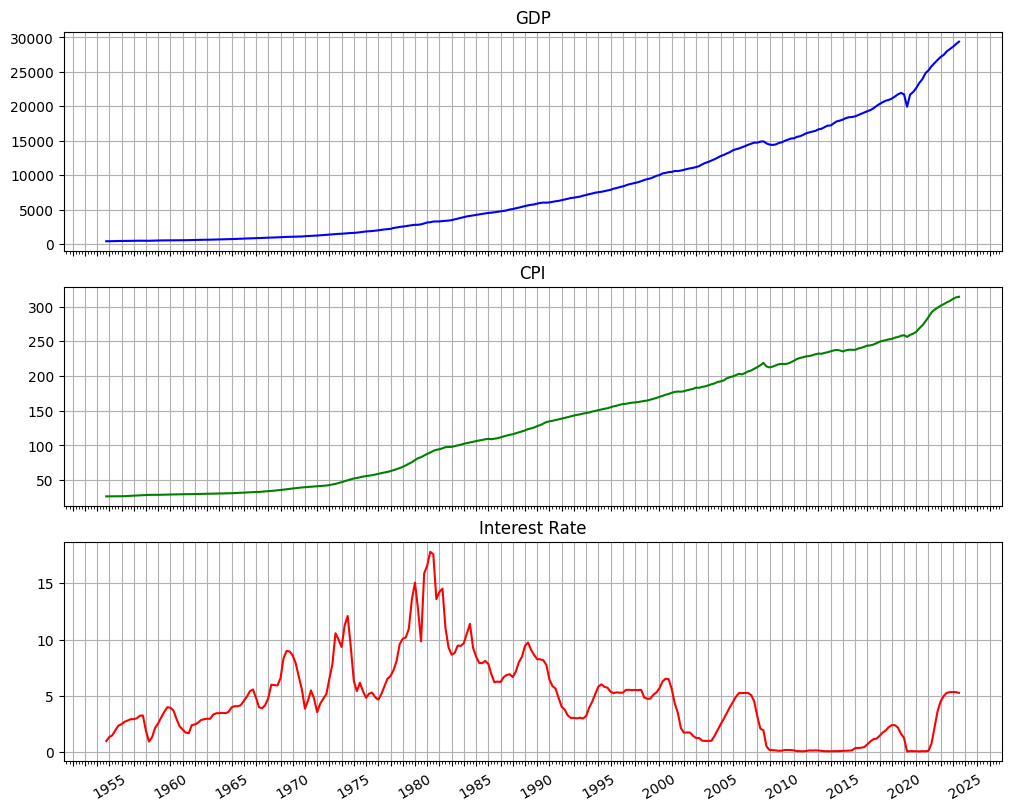

In [7]:
plot(data)

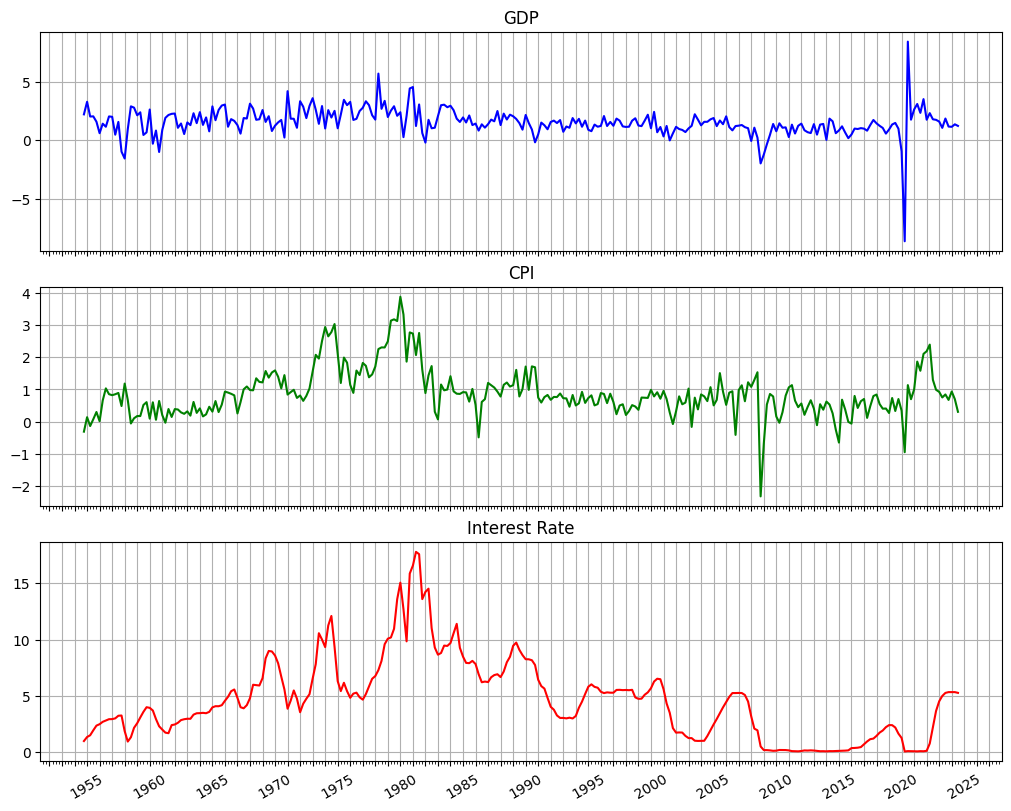

In [8]:
plot_growth(data)

In [9]:
def prepare_VAR_data(data, variable, p, p_max, intercept=True):
    y = data[variable].iloc[p_max:].reset_index(drop=True)
    X = pd.DataFrame()
    if intercept:
        X['intercept'] = np.ones(len(y))
    # Add lagged variables for all lags from 1 to p, but taking p_max into account to make sure we can properly compare the models
    for lag in range(1, p + 1):
        for var in variable:
            X[f'{var}_lag_{lag}'] = data[var].shift(lag).iloc[p_max:].reset_index(drop=True)
    return X, y

def estimate_VAR_model(y, X):
    y = np.array(y)
    X = np.array(X)
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    residuals = y - X @ beta_hat

    return beta_hat, residuals

def is_VAR_stable(phi1, phi2, phi3):
    # Make a companion form
    companion_matrix = np.vstack([
    np.hstack([phi1, phi2, phi3]),
    np.hstack([np.eye(2), np.zeros((2, 2)), np.zeros((2, 2))]),
    np.hstack([np.zeros((2, 2)), np.eye(2), np.zeros((2, 2))])
    ])

    # Compute the eigenvalues of the companion matrix
    eigenvalues = np.linalg.eigvals(companion_matrix)

    # Check if the eigenvalues are inside the unit circle
    if np.all(np.abs(eigenvalues) < 1):
        print("The VAR(3) model is stable.")
    else:
        print("The VAR(3) model is not stable.")

def compute_AIC(residuals, p, T, N):
    sigma_hat = residuals.T @ residuals / (T - p) # ML estimate of the covariance matrix
    sigma_hat_det = np.linalg.det(sigma_hat) # Determinant of MLE covariance matrix
    AIC = np.log(sigma_hat_det) + (2 * p * N**2) / T

    return AIC

# Question a

In [10]:
variable = ['DLgdp', 'DLcpi']
p = 3
p_max = 5

X, Y = prepare_VAR_data(data, variable, p, p_max)
beta_hat, residuals = estimate_VAR_model(Y, X)
omega = beta_hat[0, :]     # Intercept terms
Phi1 = beta_hat[1:3, :].T  # Lag 1 coefficients
Phi2 = beta_hat[3:5, :].T  # Lag 2 coefficients
Phi3 = beta_hat[5:7, :].T  # Lag 3 coefficients

print("Estimated coefficients for VAR(3):")
print("Omega (constant term):")
print(omega)
print('\n')
print("Phi1 (lag 1 coefficients):")
print(Phi1)
print('\n')
print("Phi2 (lag 2 coefficients):")
print(Phi2)
print('\n')
print("Phi3 (lag 3 coefficients):")
print(Phi3)
print('-'*30)
is_VAR_stable(Phi1, Phi2, Phi3)

AIC = compute_AIC(residuals, p, len(data), len(variable))
print(f"AIC: {AIC}")

Estimated coefficients for VAR(3):
Omega (constant term):
[0.86130145 0.02870205]


Phi1 (lag 1 coefficients):
[[0.09320807 0.07953361]
 [0.02195168 0.52101926]]


Phi2 (lag 2 coefficients):
[[ 0.16279649 -0.05926783]
 [ 0.0509863  -0.0133708 ]]


Phi3 (lag 3 coefficients):
[[0.02185953 0.25277642]
 [0.043032   0.2630437 ]]
------------------------------
The VAR(3) model is stable.
AIC: -1.3439623798874534


### Use built-in package VAR for validation

In [11]:
from statsmodels.tsa.api import VAR

model = VAR(data[variable])

results = model.fit(maxlags=p, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Mar, 2025
Time:                     07:52:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.14393
Nobs:                     277.000    HQIC:                  -1.25360
Log likelihood:          -588.289    FPE:                   0.265253
AIC:                     -1.32709    Det(Omega_mle):        0.252338
--------------------------------------------------------------------
Results for equation DLgdp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.860859         0.152596            5.641           0.000
L1.DLgdp         0.094663         0.065072            1.455           0.146
L1.DLcpi         0.074566         0.156353            0.477           0.633
L2.D

# Question b

In [11]:
max_lag = p_max
AIC_values = []
for lag_p in range (1, max_lag + 1):
    X, y = prepare_VAR_data(data, variable, lag_p, p_max)
    _, residuals = estimate_VAR_model(y, X)
    T = len(data)
    N = len(variable)
    AIC = compute_AIC(residuals, lag_p, T, N)
    AIC_values.append(AIC)
    print(f"AIC for VAR({lag_p}): {AIC}")

# Select the best model based on AIC
best_p = np.argmin(AIC_values) + 1
print("The best model according to AIC is VAR({})".format(best_p))

AIC for VAR(1): -1.261519755928146
AIC for VAR(2): -1.2834454941932212
AIC for VAR(3): -1.3439623798874538
AIC for VAR(4): -1.3160183907546554
AIC for VAR(5): -1.308696631152002
The best model according to AIC is VAR(3)


## Question C

In [12]:
# j = 0..20
# C_j = J * PSI^j * J'
# J = (I_N, 0, 0 ... ) NxNp matrix
# PSI = psi_formula.png
# p = 3 (best AIC), N = 2

In [22]:
p = 3
X, y = prepare_VAR_data(data, variable, p, p)
beta_hat, residuals = estimate_VAR_model(y, X)

In [55]:
omega = beta_hat[0, :]     # Intercept terms
Phi1 = beta_hat[1:3, :].T  # Lag 1 coefficients
Phi2 = beta_hat[3:5, :].T  # Lag 2 coefficients
Phi3 = beta_hat[5:7, :].T  # Lag 3 coefficients

In [56]:
I = np.eye(2)
Z = np.zeros((2, 2))

psi = np.block([
    [Phi1, Phi2, Phi3],
    [I, Z, Z],
    [Z, I, Z]
])
J = np.block([I, Z, Z])

In [59]:
# Calculate four response functions after impulses of one unit
result = []

for j in range(0, 20):
    C_j = J @ np.linalg.matrix_power(psi, j) @ J.T
    result.append(C_j)

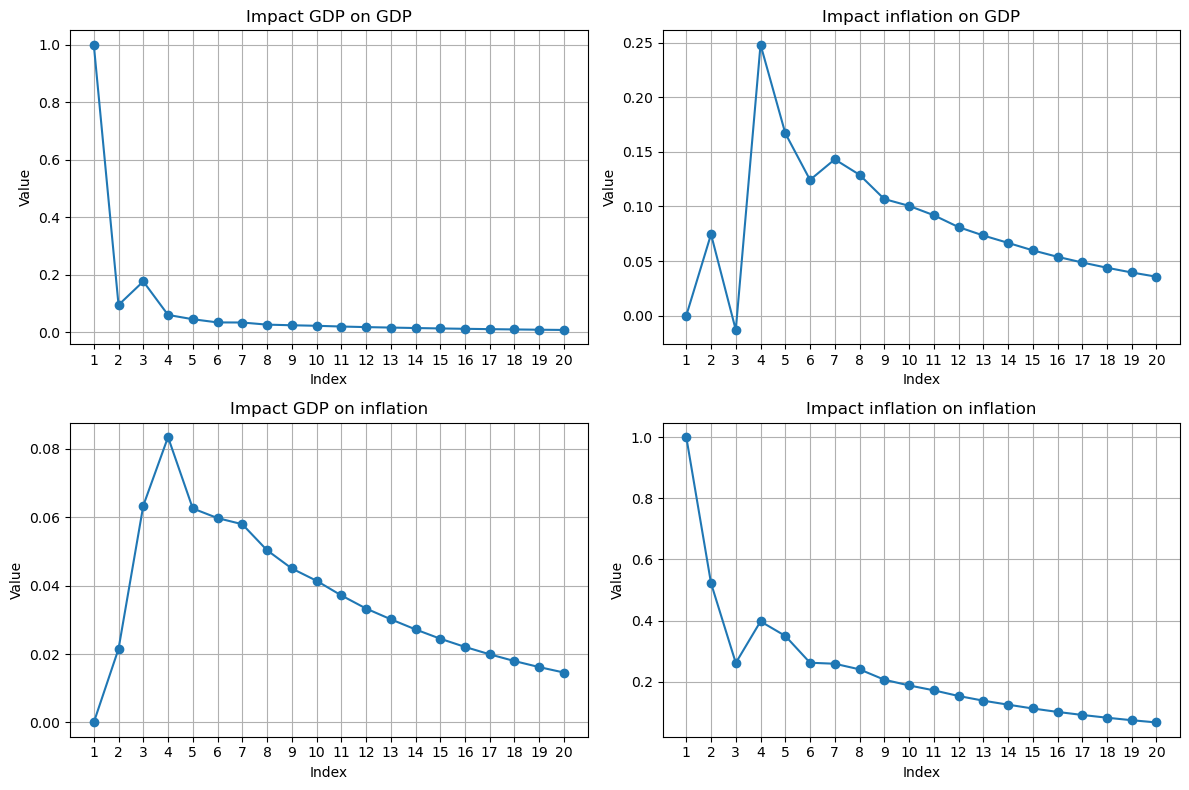

In [60]:
indices = np.arange(1, len(result) + 1)

A11 = [mat[0, 0] for mat in result]
A12 = [mat[0, 1] for mat in result]
A21 = [mat[1, 0] for mat in result]
A22 = [mat[1, 1] for mat in result]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(indices, A11, marker='o', linestyle='-')
axes[0, 0].set_title("Impact GDP on GDP")

axes[0, 1].plot(indices, A12, marker='o', linestyle='-')
axes[0, 1].set_title("Impact inflation on GDP")

axes[1, 0].plot(indices, A21, marker='o', linestyle='-')
axes[1, 0].set_title("Impact GDP on inflation")

axes[1, 1].plot(indices, A22, marker='o', linestyle='-')
axes[1, 1].set_title("Impact inflation on inflation")

for ax in axes.flat:
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.set_xticks(range(1, 21))

plt.tight_layout()
plt.show()


## Question D

In [64]:
data_out_covid = data.iloc[:quarters_short, :]

In [65]:
max_lag = p_max
AIC_values = []
for lag_p in range (1, max_lag + 1):
    X, y = prepare_VAR_data(data_out_covid, variable, lag_p, p_max)
    _, residuals = estimate_VAR_model(y, X)
    T = len(data_out_covid)
    N = len(variable)
    AIC = compute_AIC(residuals, lag_p, T, N)
    AIC_values.append(AIC)
    print(f"AIC for VAR({lag_p}): {AIC}")

# Select the best model based on AIC
best_p = np.argmin(AIC_values) + 1
print("The best model according to AIC is VAR({})".format(best_p))

AIC for VAR(1): -1.8801193669326703
AIC for VAR(2): -1.903272815407102
AIC for VAR(3): -1.9825857000672127
AIC for VAR(4): -1.97025329328748
AIC for VAR(5): -1.9640991249805453
The best model according to AIC is VAR(3)


In [66]:
p = 3
X, y = prepare_VAR_data(data_out_covid, variable, p, p)
beta_hat, residuals = estimate_VAR_model(y, X)

In [67]:
omega = beta_hat[0, :]     # Intercept terms
Phi1 = beta_hat[1:3, :].T  # Lag 1 coefficients
Phi2 = beta_hat[3:5, :].T  # Lag 2 coefficients
Phi3 = beta_hat[5:7, :].T  # Lag 3 coefficients

In [68]:
I = np.eye(2)
Z = np.zeros((2, 2))

psi = np.block([
    [Phi1, Phi2, Phi3],
    [I, Z, Z],
    [Z, I, Z]
])
J = np.block([I, Z, Z])

In [69]:
# Calculate four response functions after impulses of one unit
result = []

for j in range(0, 20):
    C_j = J @ np.linalg.matrix_power(psi, j) @ J.T
    result.append(C_j)

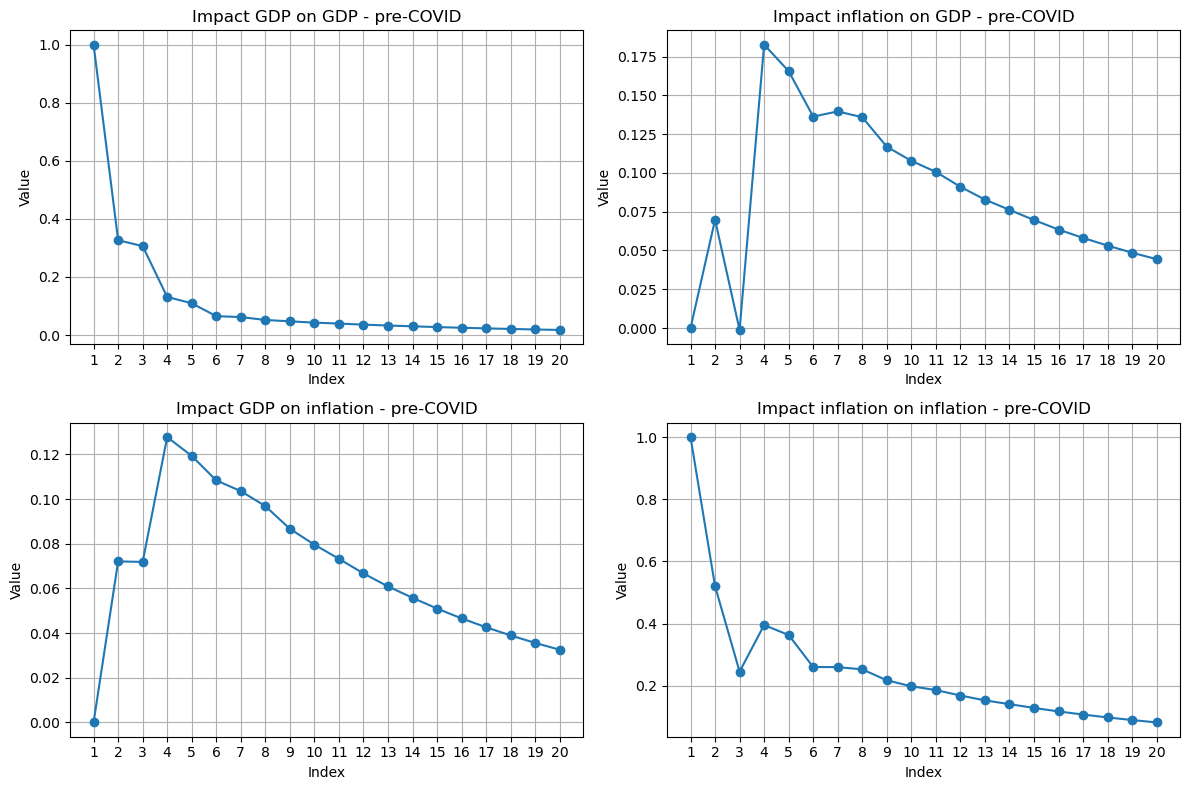

In [71]:
indices = np.arange(1, len(result) + 1)

A11 = [mat[0, 0] for mat in result]
A12 = [mat[0, 1] for mat in result]
A21 = [mat[1, 0] for mat in result]
A22 = [mat[1, 1] for mat in result]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(indices, A11, marker='o', linestyle='-')
axes[0, 0].set_title("Impact GDP on GDP - pre-COVID")

axes[0, 1].plot(indices, A12, marker='o', linestyle='-')
axes[0, 1].set_title("Impact inflation on GDP - pre-COVID")

axes[1, 0].plot(indices, A21, marker='o', linestyle='-')
axes[1, 0].set_title("Impact GDP on inflation - pre-COVID")

axes[1, 1].plot(indices, A22, marker='o', linestyle='-')
axes[1, 1].set_title("Impact inflation on inflation - pre-COVID")

for ax in axes.flat:
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.set_xticks(range(1, 21))

plt.tight_layout()
plt.show()


## Question E

In [18]:
variable_var2 = ['DLgdp', 'DLcpi','ir']
p = 2
p_max = 2 #No comparison needed in this part

X_var2, Y_var2 = prepare_VAR_data(data, variable_var2, p, p_max)
beta_hat_var2, residuals_var2 = estimate_VAR_model(Y_var2, X_var2)
omega_var2 = beta_hat_var2[0, :]     # Intercept terms
Phi1_var2 = beta_hat_var2[1:4, :].T  # Lag 1 coefficients
Phi2_var2 = beta_hat_var2[4:7, :].T  # Lag 2 coefficients

print("Estimated coefficients for VAR(2):")
print("Omega (constant term):")
print(omega_var2)
print('\n')
print("Phi1 (lag 1 coefficients):")
print(Phi1_var2)
print('\n')
print("Phi2 (lag 2 coefficients):")
print(Phi2_var2)

Estimated coefficients for VAR(2):
Omega (constant term):
[ 0.95927063  0.14405445 -0.11373933]


Phi1 (lag 1 coefficients):
[[ 8.28913558e-02  7.40444331e-02  1.12510840e-01]
 [-4.75169659e-04  5.02833301e-01  1.58674856e-01]
 [ 1.73947641e-01 -2.49253509e-01  1.16659236e+00]]


Phi2 (lag 2 coefficients):
[[ 0.12986986  0.11776769 -0.09621189]
 [ 0.00197216  0.1817107  -0.13018346]
 [ 0.06637723  0.34407744 -0.23764074]]


## Part F

In [44]:
# Drop lags of IR for restricted model
X_var2_R = X_var2.drop(columns=['ir_lag_1','ir_lag_2'])

X_var2_R, residuals_var2_R = estimate_VAR_model(Y_var2,X_var2_R)

SSR_1 = np.sum(residuals_var2 ** 2)  # Sum of squared residuals for unrestricted model
SSR_0 = np.sum(residuals_var2_R ** 2) # Sum of squared residuals for restricted model

T = X_var2.shape[0] # Observations
k = X_var2.shape[1] # Number of regressors in the unrestricted model
q = X_var2_R.shape[1] # Number of regressors in the restricted model

F = ((T-k)/q) * ((SSR_0-SSR_1)/SSR_1)

In [45]:
F

np.float64(262.04499098085137)